In [75]:
import pandas as pd
import numpy as np
from dateutil import parser
import re
import matplotlib.pyplot as plt
import gc
from copy import deepcopy

plt.style.use('ggplot')

In [28]:
books = pd.read_csv('data/books.csv')
checkouts = pd.read_csv('data/checkouts.csv')
customers = pd.read_csv('data/customers.csv')
libraries = pd.read_csv('data/libraries.csv')

In [29]:
late_return_time = 28

## Cleaning Dates
---

* Date formats aren't unified so we can't use the 'parse_dates' argument of 'read_csv()'
* Need to clean them before parsing

In [30]:
def date_cleaner(x):
    return re.sub(r'[%|]', ' ', x)

parse_date = lambda x: np.nan if x is np.nan else parser.parse(date_cleaner(x))

In [31]:
checkouts['date_checkout'] = checkouts['date_checkout'].apply(parse_date)
checkouts['date_returned'] = checkouts['date_returned'].apply(parse_date)
books['publishedDate'] = books['publishedDate'].apply(parse_date)
customers['birth_date'] = customers['birth_date'].apply(parse_date)

In [32]:
print('date_checkout max: ' + str(max(checkouts['date_checkout'])))
print('date_checkout min: ' + str(min(checkouts['date_checkout'])))

print('date_returned max: ' + str(max(checkouts['date_returned'])))
print('date_returned min: ' + str(min(checkouts['date_returned'])))

print('publishedDate max: ' + str(max(books['publishedDate'])))
print('publishedDate min: ' + str(min(books['publishedDate'])))

print('birth_date max: ' + str(max(customers['birth_date'])))
print('birth_date min: ' + str(min(customers['birth_date'])))

date_checkout max: 2120-09-06 00:00:00
date_checkout min: 1800-08-09 00:00:00
date_returned max: 2120-09-14 00:00:00
date_returned min: 1800-04-28 00:00:00
publishedDate max: 2021-02-17 00:00:00
publishedDate min: 1830-01-05 00:00:00
birth_date max: 2120-08-25 00:00:00
birth_date min: 1800-02-19 00:00:00


* There are dates in the future and in the distant past, these should be removed before analysis

array([<Axes: title={'center': 'date_returned'}>], dtype=object)

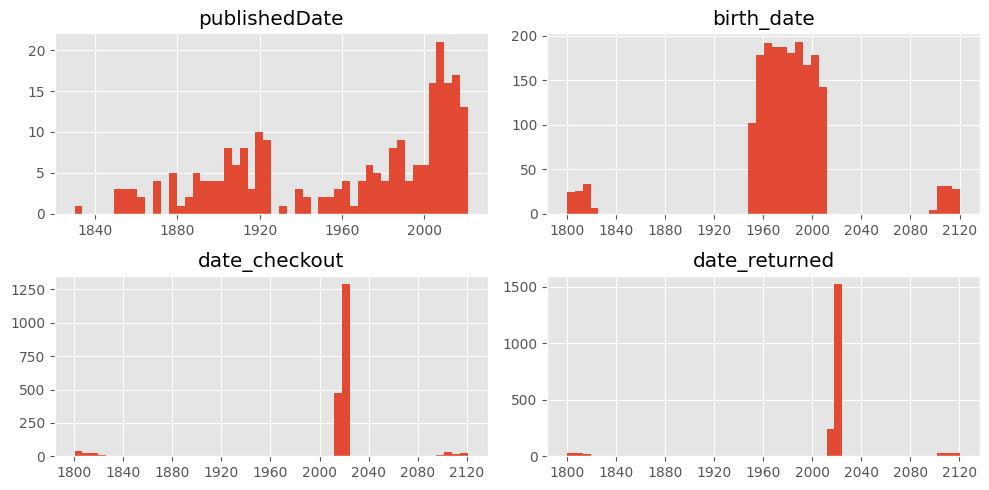

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), tight_layout=True)
books.hist(column='publishedDate', bins=50, ax=ax[0][0])
customers.hist(column='birth_date', bins=50, ax=ax[0][1])
checkouts.hist(column='date_checkout', bins=50, ax=ax[1][0])
checkouts.hist(column='date_returned', bins=50, ax=ax[1][1])

* Looking at histograms, we can conclude that these are outliers and can be removed using IQR
* If this was not the case, we could find library opening years and use this as minimum possible date, and remove minors or persons above a certain age from customers column
* For now, these values will be replaced by nan

In [34]:
def replace_outliers(df, col):
    IQR = (q1:=df[col].quantile(0.75)) - (q2:=df[col].quantile(0.25))

    df.loc[(df[col] < q1-1.5*IQR)|(df[col] > q2+1.5*IQR), col] = np.nan

In [35]:
replace_outliers(customers, 'birth_date')
replace_outliers(checkouts, 'date_checkout')
replace_outliers(checkouts, 'date_returned')

array([<Axes: title={'center': 'date_returned'}>], dtype=object)

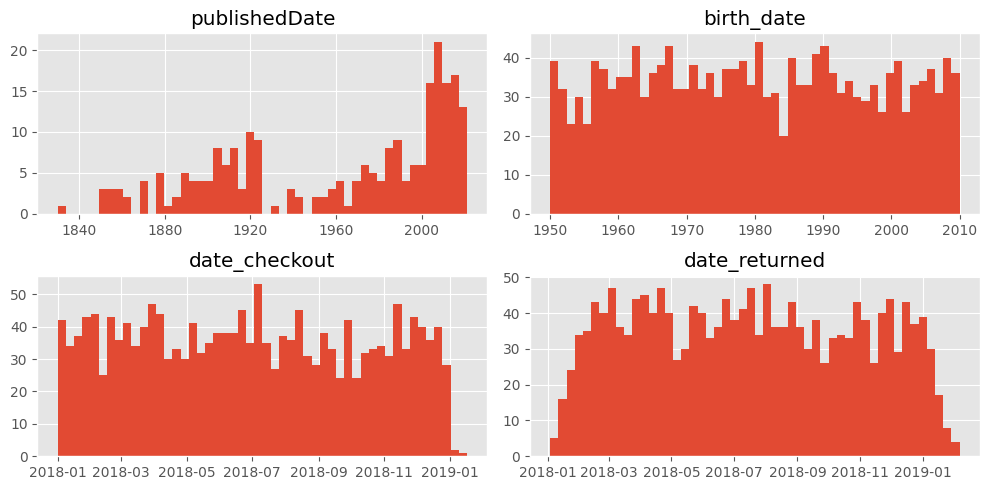

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), tight_layout=True)
books.hist(column='publishedDate', bins=50, ax=ax[0][0])
customers.hist(column='birth_date', bins=50, ax=ax[0][1])
checkouts.hist(column='date_checkout', bins=50, ax=ax[1][0])
checkouts.hist(column='date_returned', bins=50, ax=ax[1][1])

### Removing unusable rows

* Rows from checkouts table with missing or incorrect dates cannot be used for prediction, so these will be removed
* Due to legal constraints with processing minors data, customers under 13 years of age (at the time of checkout) will be removed from the dataset. 

In [37]:
checkouts_clean = checkouts[(~checkouts['date_checkout'].isna())&(~checkouts['date_returned'].isna())]

In [38]:
processing_age = 13

customers_tmp = customers[['id', 'birth_date']].merge(checkouts[['patron_id', 'date_checkout']], left_on='id', right_on='patron_id')
ids_to_remove = customers_tmp[(customers_tmp['date_checkout']-customers_tmp['birth_date'])<pd.to_timedelta(processing_age*365.25, unit='day')].patron_id

del customers_tmp
gc.collect()

314

In [39]:
checkouts_clean = checkouts_clean[~checkouts_clean.patron_id.isin(ids_to_remove)]
customers_clean = customers[~customers.id.isin(ids_to_remove)]

# Cleaning Categorical Columns
---

* Looking at customers table, we can see discrepancies in how categorical values are entered
* These should be normalized before further processing

In [48]:
customers_clean.groupby('occupation')['id'].count()

occupation
  Business &  Finance    1
 Admin & Support         1
 Blue  Collar            1
 Blue Collar             1
 Blue Collar             1
                        ..
education & HEALTH       1
education & Health       4
others                   1
sales                    2
tech                     6
Name: id, Length: 70, dtype: int64

In [47]:
customers_clean.groupby('education')['id'].count()

education
 College              15
 Graduate  Degree      3
 Graduate Degree       1
 High  School          1
 High School           1
 Others                8
COLLEGE               15
College              394
College               11
GRADUATE DEGREE        1
GRADUATE Degree        8
GRADUATE degree        1
Graduate   Degree      2
Graduate  Degree       8
Graduate  Degree       2
Graduate DEGREE       13
Graduate Degree      376
Graduate Degree        1
Graduate degree        2
HIGH SCHOOL            3
HIGH School            5
HIGH school            3
High   School          6
High  School           7
High  School           3
High SCHOOL            5
High School          430
High School            1
High School            1
High school            3
OTHERS                16
Others               408
Others                11
college                6
graduate DEGREE        2
graduate Degree        1
high SCHOOL            1
high School            1
others                 7
Name: id, dtype

In [46]:
customers_clean.groupby('gender')['id'].count()

gender
 female     22
 male       20
FEMALE      29
MALE        45
female     805
female      22
male       819
male        24
Name: id, dtype: int64

In [45]:
customers_clean.groupby('state')['id'].count()

state
 Oregon          47
 Washington       2
OREGON           65
Oregon         1570
Oregon           44
Washington       41
Washington        1
oregon           23
washington        1
Name: id, dtype: int64

In [44]:
customers_clean.groupby('city')['id'].count()

city
 Beaverton           1
 Portland           39
 Vancouver           4
BEAVERTON            1
Beaverton           20
CLACKAMAS            1
Clackamas            2
Damascus             2
Gladstone            1
Gresham              3
HAPPY Valley         1
Happy  Valley        1
Happy  Valley        1
Happy Valley        25
Happy Valley         1
Hillsboro            1
LAKE OSWEGO          1
Lake   Oswego        1
Lake  Oswego         1
Lake OSWEGO          1
Lake Oswego         23
Oregon City          4
PORTLAND            56
Portland          1500
Portland            40
Tualatin             8
VANCOUVER            1
Vancouver           37
Vancouver            1
West Linn            9
portland            12
vancouver            1
Name: id, dtype: int64

### String normalization

* Malformed strings appear in customers and libraries tables

In [56]:
def normalize_string(x):
    x = x.lower() # transforms everything to lowercase
    x = re.sub(' +', ' ', x) # merges multiple whitespaces
    x = x.strip() # removes leading and trailing whitespaces
    return x

In [86]:
for col in ['name', 'city', 'region', 'street_address']:
    libraries.loc[:, col] = libraries[col].apply(lambda x: np.nan if x is np.nan else normalize_string(x))

for col in ['name', 'city', 'state', 'street_address', 'gender', 'education', 'occupation']:
    customers_clean.loc[:, col] = customers_clean[col].apply(lambda x: np.nan if x is np.nan else normalize_string(x))

# Numerical Columns Cleaning
---